# Re-constraining the "large" ensemble

Theme Song: Song II<br>
Artist: Blur<br>
Album: Blur<br>
Released: 1997

For a different project.

Drop the requirement to hit the Chapter 5 TCRE assessment to get more ensemble members (not observationally based, so fine).

In [1]:
import json
import random
import numpy as np
import scipy.stats as st       # v1.4+ needed
import matplotlib.pyplot as pl
import pandas as pd
import pickle
import warnings
from multiprocessing import Pool

from netCDF4 import Dataset
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from scipy.optimize import root
from fair.constants import molwt
from fair.ancil import natural, cmip6_volcanic, cmip6_solar
from fair.forward import fair_scm
from fair.inverse import inverse_fair_scm
from fair.constants.general import ppm_gtc, EARTH_RADIUS, SECONDS_PER_YEAR
NTOA_ZJ = 4 * np.pi * EARTH_RADIUS**2 * SECONDS_PER_YEAR * 1e-21

In [2]:
pl.rcParams['figure.figsize'] = (12/2.54, 9/2.54)
pl.rcParams['font.size'] = 14
pl.rcParams['font.family'] = 'Arial'
pl.rcParams['xtick.direction'] = 'out'
pl.rcParams['xtick.minor.visible'] = True
pl.rcParams['ytick.minor.visible'] = True
pl.rcParams['ytick.right'] = True
pl.rcParams['xtick.top'] = True
pl.rcParams['figure.dpi'] = 96

## Observational data

1.2563235294117647

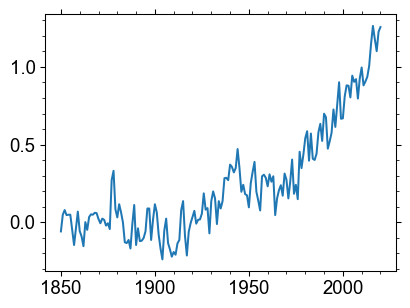

In [4]:
xl = pd.read_excel('../data_input/observations/AR6 FGD assessment time series - GMST and GSAT.xlsx', skiprows=1, skipfooter=28)
temp_gmst=xl['4-set mean'].values
temp_year=xl['Unnamed: 0'].values
pl.plot(temp_year, temp_gmst)

temp_gmst[-1]

In [5]:
OHC_df = pd.read_csv("../data_input/observations/AR6_OHC_ensemble_FGDprelim.csv", skiprows=1)
OHC_df

,Year,Central Estimate 0-700m,0-700m Uncertainty (1-sigma),Central Estimate 700-2000m,700-2000m Uncertainty (1-sigma,Central Estimate >2000m,>2000m Uncertainty (1-sigma),Central Estimate Full-depth,Full-depth Uncertainty (1-sigma)
0,1971.5,0.000000,46.719967,0.000000,12.660520,0.00,0.000000,0.000000,59.380488
1,1972.5,9.791417,46.491790,-0.277343,13.196417,0.00,0.000000,9.514074,59.688206
2,1973.5,4.528171,50.269297,-3.910480,14.898312,0.00,0.000000,0.617691,65.167609
3,1974.5,11.580189,52.396967,1.635750,15.118808,0.00,0.000000,13.215939,67.515775
4,1975.5,4.454305,53.868706,4.517913,15.285554,0.00,0.000000,8.972219,69.154259
5,1976.5,18.985673,54.101031,7.868500,15.087668,0.00,0.000000,26.854173,69.188699
6,1977.5,18.069725,53.131147,6.285167,14.375839,0.00,0.000000,24.354892,67.506986
7,1978.5,34.943991,49.275054,4.770844,12.514669,0.00,0.000000,39.714835,61.789724
8,1979.5,46.680326,48.300047,7.726577,10.164641,0.00,0.000000,54.406903,58.464688
9,1980.5,65.130278,47.629291,9.711603,9.248468,0.00,0.000000,74.841882,56.877759


In [6]:
OHUobs = OHC_df['Central Estimate Full-depth'].values
OHUyears = OHC_df['Year'].values

In [7]:
OHU90 = OHC_df['Full-depth Uncertainty (1-sigma)'].values

## Ensemble generation

We want to ensure reproducible results that don't change when this script is re-run. Grab list of pre-generated random seeds.

In [8]:
with open('../data_input/random_seeds.json', 'r') as filehandle:
    SEEDS = json.load(filehandle)

In [9]:
SAMPLES = 1000000
F2XCO2_MEAN = 4.00
F2XCO2_NINETY = 0.48

## Thermal parameters

In [10]:
geoff_sample_df = pd.read_csv('../data_output_large/geoff_sample.csv', index_col=0)
geoff_sample_df

,q4x,lamg,cmix,cdeep,gamma_2l,eff
0,8.142751,-1.156137,9.493752,56.066688,0.455056,1.344132
1,6.119064,-2.167808,8.747261,52.676899,0.461327,1.077195
2,8.617112,-1.293838,8.009019,123.943687,0.566571,1.153560
3,7.946020,-1.305245,7.816008,19.885165,0.608541,1.879368
4,8.254456,-0.987906,8.534034,27.923307,0.584929,1.258868
...,...,...,...,...,...,...
999995,8.206094,-1.894573,7.723174,42.723816,0.446202,0.863636
999996,6.976153,-0.866711,7.675436,95.031285,0.601062,1.119801
999997,6.400432,-1.332822,6.259983,76.463621,0.655916,1.157176
999998,8.308545,-1.364315,9.187381,59.919601,0.596989,1.331847


In [11]:
ecs = np.load('../data_input_large/fair-samples/ecs_unconstrained.npy')
tcr = np.load('../data_input_large/fair-samples/tcr_unconstrained.npy')
f2x = np.load('../data_input_large/fair-samples/f2x_unconstrained.npy')

## Carbon cycle parameters

Uniform distributions from Leach et al

In [12]:
r0 = np.load('../data_input_large/fair-samples/r0_unconstrained.npy')
rC = np.load('../data_input_large/fair-samples/rC_unconstrained.npy')
rT = np.load('../data_input_large/fair-samples/rT_unconstrained.npy')
pre_ind_co2 = np.load('../data_input_large/fair-samples/pre_ind_co2_unconstrained.npy')

# Constraining starts here

In [13]:
C_CO2 = np.load('../data_output_large/fair-samples/C_CO2_unconstrained.npy')
F_O3 = np.load('../data_output_large/fair-samples/F_O3_unconstrained.npy')
F_dir = np.load('../data_output_large/fair-samples/F_ERFari_unconstrained.npy')
F_ind = np.load('../data_output_large/fair-samples/F_ERFaci_unconstrained.npy')
F_ant = np.load('../data_output_large/fair-samples/F_anthro_unconstrained.npy')
F_tot = np.load('../data_output_large/fair-samples/F_total_unconstrained.npy')
T = np.load('../data_output_large/fair-samples/T_unconstrained.npy')
OHU = np.load('../data_output_large/fair-samples/OHU_unconstrained.npy')
AF = np.load('../data_output_large/fair-samples/AF_unconstrained.npy')

In [14]:
F_O3.shape

(351, 1000000)

In [15]:
def rmse(obs, mod):
    return np.sqrt(np.sum((obs-mod)**2)/len(obs))

## 1. GMST 1850-2019

In [16]:
## simple criterion: RMSE of temperature 1850-2014 < 0.135
rmse_temp = np.zeros((SAMPLES))
for i in range(SAMPLES):
    rmse_temp[i] = rmse(temp_gmst[:165], (T[100:265,i]-np.mean(T[100:151,i], axis=0)))
accept_temp=(rmse_temp<0.135)
print(np.sum(accept_temp))
valid_temp = np.arange(SAMPLES, dtype=int)[accept_temp]

311968


In [17]:
# accept_temp = np.logical_and(
#     T[245:265].mean(axis=0)-T[100:151].mean(axis=0) < 0.98,
#     0.67 < T[245:265].mean(axis=0)-T[100:151].mean(axis=0)
# )
# valid_temp = np.arange(SAMPLES, dtype=int)[accept_temp]
# print(np.sum(accept_temp))

(array([ 3181., 21828., 38806., 46337., 49144., 48108., 44365., 37295.,
        19853.,  3051.]),
 array([0.62422508, 0.67057784, 0.71693061, 0.76328338, 0.80963615,
        0.85598892, 0.90234169, 0.94869445, 0.99504722, 1.04139999,
        1.08775276]),
 <a list of 10 Patch objects>)

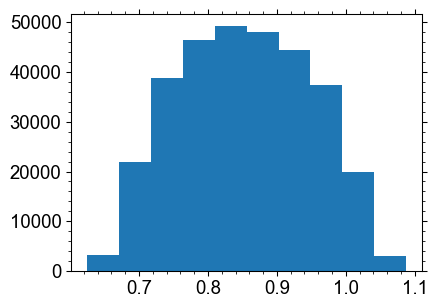

In [18]:
pl.hist(T[245:265,accept_temp].mean(axis=0) - T[100:151,accept_temp].mean(axis=0))

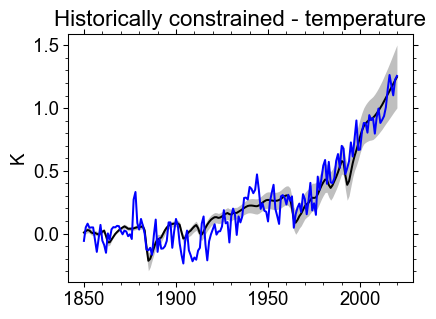

In [19]:
pl.fill_between(
    np.arange(1850, 2021),
    np.percentile(T[100:271,accept_temp]-np.mean(T[100:151,accept_temp], axis=0), 5, axis=1),
    np.percentile(T[100:271,accept_temp]-np.mean(T[100:151,accept_temp], axis=0), 95, axis=1), 
    color='gray', lw=0, alpha=0.5
)
pl.plot(
    np.arange(1850, 2021), 
    np.percentile(T[100:271,accept_temp]-np.mean(T[100:151,accept_temp], axis=0), 50, axis=1),
    color='k'
)
pl.plot(np.arange(1850, 2021), temp_gmst, color='blue')
pl.title('Historically constrained - temperature')
pl.ylabel('K')
pl.tight_layout()

In [20]:
# GMST target 0.67 0.85 0.98
print(np.percentile(np.mean(T[245:265,accept_temp], axis=0)-np.mean(T[100:151,accept_temp], axis=0), (5, 16, 50, 84, 95)))

[0.70169938 0.74798212 0.85284385 0.96028097 1.00712533]


## 2. Ocean heat uptake 1971-2018

In [21]:
((OHUobs[-1]-OHUobs[0]) - np.sqrt(OHU90[0]**2+OHU90[-1]**2))

328.2073313385383

In [22]:
accept_ohu = np.logical_and(
    ((OHUobs[-1]-OHUobs[0]) - np.sqrt(OHU90[0]**2+OHU90[-1]**2)) < 0.90*(OHU[268,:]-OHU[221,:])*1e-21,
    0.90*(OHU[268,:]-OHU[221,:])*1e-21 < ((OHUobs[-1]-OHUobs[0]) + np.sqrt(OHU90[0]**2+OHU90[-1]**2))
)
valid_ohu = np.arange(SAMPLES, dtype=int)[accept_ohu]
print(np.sum(accept_ohu))

322738


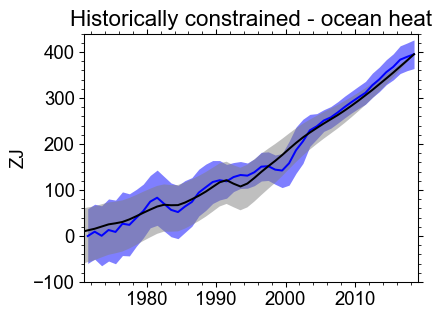

In [23]:
pl.fill_between(OHUyears, OHUobs-OHU90, OHUobs+OHU90, color='blue', lw=0, alpha=0.5)
pl.plot(OHUyears, OHUobs, color='blue')
pl.fill_between(np.arange(1750.5, 2019), OHUobs[-1]+1e-21*np.percentile(0.90*(OHU[:269,accept_ohu]-OHU[268,accept_ohu]), 5, axis=1), OHUobs[-1]+1e-21*np.percentile(0.90*(OHU[:269,accept_ohu]-OHU[268,accept_ohu]), 95, axis=1), color='gray', lw=0, alpha=0.5)
pl.plot(np.arange(1750.5,2019), OHUobs[-1]+1e-21*np.percentile(0.90*(OHU[:269,accept_ohu]-OHU[268,accept_ohu]), 50, axis=1), color='k')
pl.title('Historically constrained - ocean heat')
pl.xlim(1971,2019)
pl.ylim(-100,440)
pl.ylabel('ZJ')
pl.tight_layout()

## 3. CO2 concentrations in 2014*

*avoids scenario selection effects

In [24]:
conc_all = pd.read_csv('../data_input_large/rcmip-concentrations-annual-means-v5-1-0.csv')
co2_obs = conc_all[(conc_all['Scenario']=='ssp245')&(conc_all['Region']=='World')&(conc_all.Variable.str.endswith('CO2'))].loc[:,'1750':'2018'].values.squeeze()
co2_obs.shape

(269,)

(array([1.90000e+01, 8.26000e+02, 1.57470e+04, 1.13282e+05, 3.21406e+05,
        3.60226e+05, 1.59118e+05, 2.75140e+04, 1.81800e+03, 4.40000e+01]),
 array([262.24068083, 265.15863001, 268.07657918, 270.99452835,
        273.91247753, 276.8304267 , 279.74837588, 282.66632505,
        285.58427423, 288.5022234 , 291.42017258]),
 <a list of 10 Patch objects>)

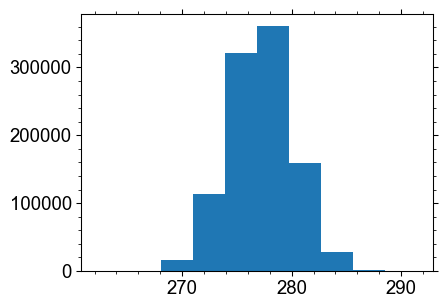

In [25]:
pl.hist(C_CO2[0,:])

In [26]:
C_CO2.shape

(351, 1000000)

In [27]:
accept_co2 = np.logical_and( (co2_obs[264] - 0.36) < C_CO2[264], C_CO2[264] < (co2_obs[264] + 0.36) )
print(np.sum(accept_co2))
valid_co2 = np.arange(SAMPLES, dtype=int)[accept_co2]

21560


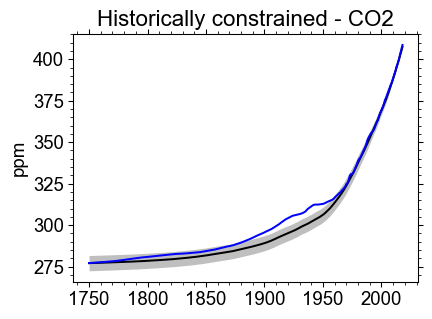

In [28]:
pl.fill_between(
    np.arange(1750, 2019),
    np.percentile(C_CO2[:269,accept_co2], 5, axis=1),
    np.percentile(C_CO2[:269,accept_co2], 95, axis=1), 
    color='gray', lw=0, alpha=0.5
)
pl.plot(
    np.arange(1750, 2019), 
    np.percentile(C_CO2[:269,accept_co2], 50, axis=1),
    color='k'
)
pl.plot(np.arange(1750, 2019), co2_obs, color='blue')
pl.title('Historically constrained - CO2')
pl.ylabel('ppm')
pl.tight_layout()

(array([1774., 2134., 2257., 2356., 2357., 2414., 2471., 2408., 2065.,
        1324.]),
 array([-0.00711718, -0.00158699,  0.0039432 ,  0.00947339,  0.01500358,
         0.02053376,  0.02606395,  0.03159414,  0.03712433,  0.04265451,
         0.0481847 ]),
 <a list of 10 Patch objects>)

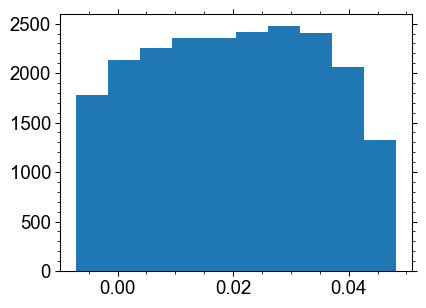

In [29]:
pl.hist(rC[accept_co2])

In [30]:
accept_ssp245 = accept_temp * accept_ohu * accept_co2
accept_inds = (np.arange(len(accept_ssp245), dtype=int))[accept_ssp245]
accept_inds

array([   149,    156,    358, ..., 999021, 999584, 999985])

In [31]:
len(accept_inds)

3751

(array([350., 348., 376., 405., 412., 403., 440., 422., 382., 213.]),
 array([-0.00711718, -0.00158967,  0.00393784,  0.00946536,  0.01499287,
         0.02052038,  0.02604789,  0.0315754 ,  0.03710291,  0.04263042,
         0.04815793]),
 <a list of 10 Patch objects>)

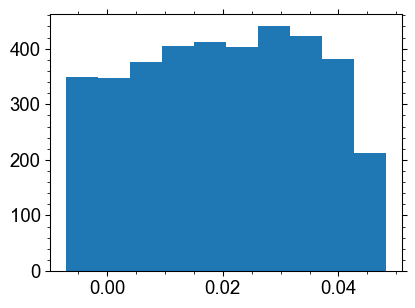

In [32]:
pl.hist(rC[accept_inds])

(array([376., 382., 392., 371., 409., 382., 367., 360., 337., 375.]),
 array([-0.08446368,  0.37591458,  0.83629284,  1.29667109,  1.75704935,
         2.2174276 ,  2.67780586,  3.13818411,  3.59856237,  4.05894063,
         4.51931888]),
 <a list of 10 Patch objects>)

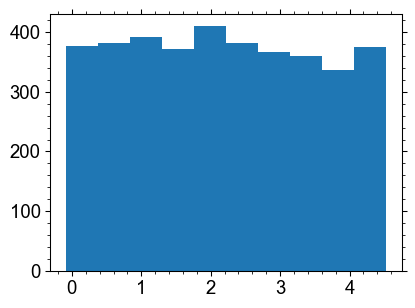

In [33]:
pl.hist(rT[accept_inds])

(array([0.0684258 , 0.08313049, 0.08607142, 0.08509111, 0.0762683 ,
        0.08175805, 0.07901318, 0.07352343, 0.06097543, 0.04117312]),
 array([27.70139266, 29.06114078, 30.42088889, 31.78063701, 33.14038513,
        34.50013324, 35.85988136, 37.21962948, 38.5793776 , 39.93912571,
        41.29887383]),
 <a list of 10 Patch objects>)

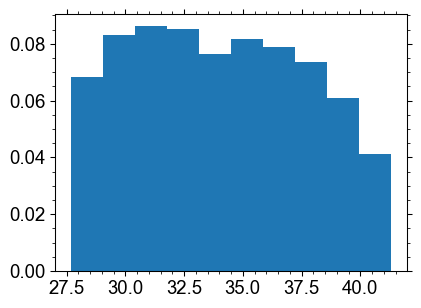

In [34]:
pl.hist(r0[accept_inds], density=True)

Text(0.5, 1.0, 'Historically constrained - CO2')

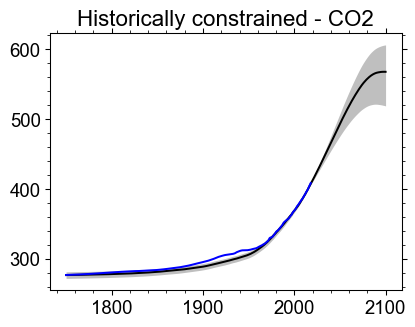

In [36]:
pl.fill_between(
    np.arange(1750, 2101),
    np.percentile(C_CO2[:,accept_inds], 5, axis=1),
    np.percentile(C_CO2[:,accept_inds], 95, axis=1), 
    color='gray', lw=0, alpha=0.5
)
pl.plot(
    np.arange(1750, 2101), 
    np.percentile(C_CO2[:,accept_inds], 50, axis=1),
    color='k'
)
pl.plot(np.arange(1750, 2019), co2_obs, color='blue')
pl.title('Historically constrained - CO2')

Text(0.5, 1.0, 'Historically constrained - temperature')

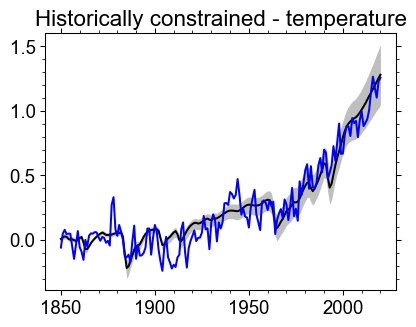

In [38]:
pl.fill_between(
    np.arange(1850, 2021),
    np.percentile(T[100:271,accept_inds]-np.mean(T[100:151,accept_inds], axis=0), 5, axis=1),
    np.percentile(T[100:271,accept_inds]-np.mean(T[100:151,accept_inds], axis=0), 95, axis=1), 
    color='gray', lw=0, alpha=0.5
)
pl.plot(
    np.arange(1850, 2021), 
    np.percentile(T[100:271,accept_inds]-np.mean(T[100:151,accept_inds], axis=0), 50, axis=1),
    color='k'
)
pl.plot(np.arange(1850, 2021), temp_gmst, color='blue')
pl.title('Historically constrained - temperature')

In [40]:
# target 0.67 0.85 0.98 GMST
#print(np.percentile((np.mean(T[245:265,accept], axis=0)-np.mean(T[100:151,accept], axis=0))/1.04, (5, 16, 50, 84, 95)))
print(np.percentile(np.mean(T[245:265,accept_inds], axis=0)-np.mean(T[100:151,accept_inds], axis=0), (5, 16, 50, 84, 95)))

[0.72851961 0.78135389 0.87728593 0.97047125 1.01207135]


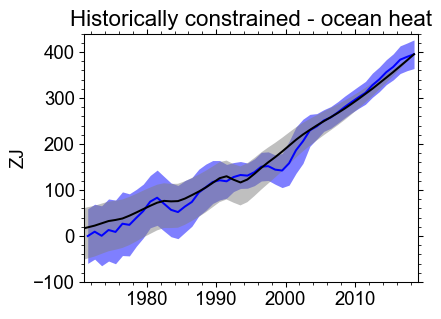

In [41]:
pl.fill_between(OHUyears, OHUobs-OHU90, OHUobs+OHU90, color='blue', lw=0, alpha=0.5)
pl.plot(OHUyears, OHUobs, color='blue')
pl.fill_between(np.arange(1750.5, 2019), OHUobs[-1]+1e-21*np.percentile(0.90*(OHU[:269,accept_inds]-OHU[268,accept_inds]), 5, axis=1), OHUobs[-1]+1e-21*np.percentile(0.90*(OHU[:269,accept_inds]-OHU[268,accept_inds]), 95, axis=1), color='gray', lw=0, alpha=0.5)
pl.plot(np.arange(1750.5,2019), OHUobs[-1]+1e-21*np.percentile(0.90*(OHU[:269,accept_inds]-OHU[268,accept_inds]), 50, axis=1), color='k')
pl.title('Historically constrained - ocean heat')
pl.xlim(1971,2019)
pl.ylim(-100,440)
pl.ylabel('ZJ')
pl.tight_layout()

In [42]:
# target 0.67 0.85 0.98 GMST
np.percentile(np.mean(T[245:265,accept_inds],axis=0)-np.mean(T[100:151,accept_inds],axis=0), (5,16,50,84,95))

array([0.72851961, 0.78135389, 0.87728593, 0.97047125, 1.01207135])

array([2.04200537, 2.3413273 , 2.95374193, 3.9547568 , 5.12734391])

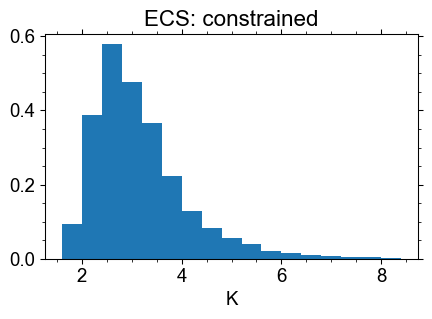

In [43]:
pl.hist(ecs[accept_inds], bins=np.arange(1.6,8.8,0.4), density=True)
# target 2.0 2.5 3.0 4.0 5.0
pl.xlabel('K')
pl.title('ECS: constrained')
pl.tight_layout()
np.percentile(ecs[accept_inds], (5,16,50,84,95))

array([1.31024952, 1.48194467, 1.8109406 , 2.2322708 , 2.56574913])

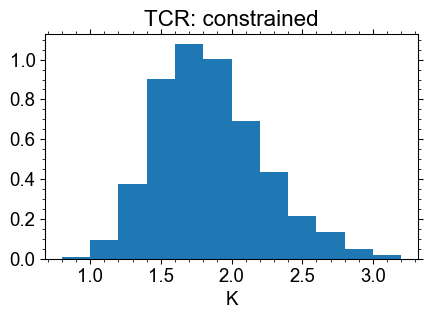

In [44]:
pl.hist(tcr[accept_inds], bins=np.arange(0.8,3.2,0.2), density=True)
# target 1.2 1.4 1.8 2.2 2.4
pl.xlabel('K')
pl.title('TCR: constrained')
pl.tight_layout()
np.percentile(tcr[accept_inds], (5,16,50,84,95))

array([-0.55967043, -0.44872886, -0.2755159 , -0.10525752, -0.00712267])

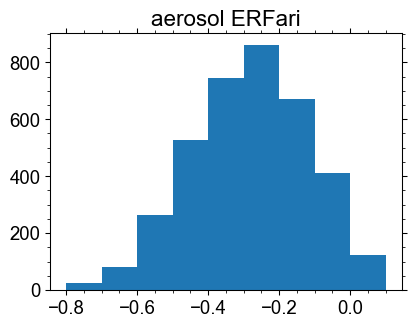

In [45]:
# target -0.6 -0.3 -0.0
pl.hist(np.mean(F_dir[255:265,accept_inds], axis=0), bins=np.arange(-0.8,0.2,0.1));
pl.title('aerosol ERFari')
np.percentile(np.mean(F_dir[255:265,accept_inds], axis=0), (5,16,50,84,95))

array([-1.41568443, -1.19271146, -0.87983332, -0.552052  , -0.33864473])

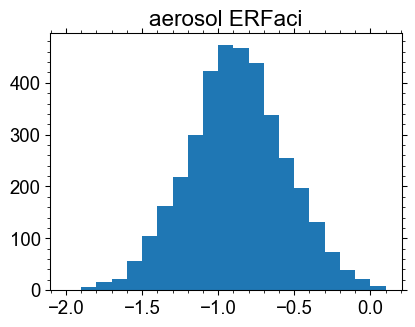

In [46]:
# target -1.7 -1.0 -0.3
pl.hist(np.mean(F_ind[255:265,accept_inds], axis=0), bins=np.arange(-2.0,0.2,0.1));
pl.title('aerosol ERFaci')
np.percentile(np.mean(F_ind[255:265,accept_inds], axis=0), (5,16,50,84,95))

array([-1.69166665, -1.47519286, -1.1494846 , -0.83426407, -0.60355818])

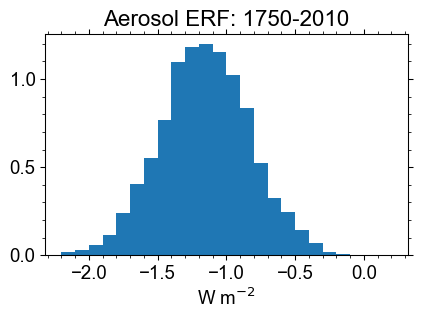

In [47]:
# target -2 -1.3 -0.6
pl.hist(np.mean(F_dir[255:265,accept_inds], axis=0)+np.mean(F_ind[255:265,accept_inds], axis=0), bins=np.arange(-2.2,0.2,0.1), density=True);
pl.title('Aerosol ERF: 1750-2010')
pl.xlabel('W m$^{-2}$')
pl.tight_layout()
np.percentile(np.mean(F_dir[255:265,accept_inds], axis=0)+np.mean(F_ind[255:265,accept_inds], axis=0), (5,16,50,84,95))

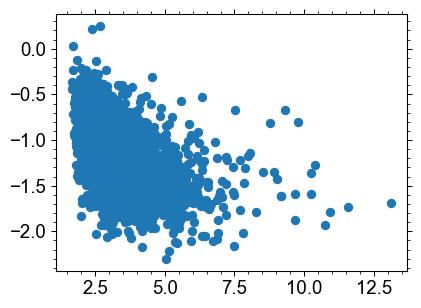

In [48]:
pl.scatter(ecs[accept_inds], np.mean(F_dir[255:265,accept_inds], axis=0)+np.mean(F_ind[255:265,accept_inds], axis=0))

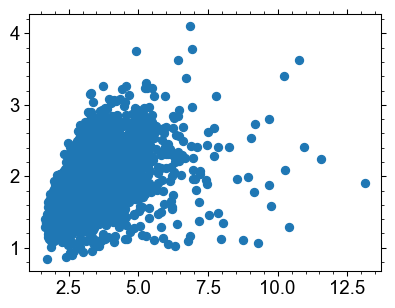

In [49]:
pl.scatter(ecs[accept_inds], tcr[accept_inds])

## Save arg lists that pass constraint for running openscm-runner

In [50]:
# ozone
ozone_feedback = np.load('../data_input_large/fair-samples/ozone_feedback_unconstrained.npy')
beta_ch4 = np.load('../data_input_large/fair-samples/beta_ch4_unconstrained.npy')
beta_n2o = np.load('../data_input_large/fair-samples/beta_n2o_unconstrained.npy')
beta_ods = np.load('../data_input_large/fair-samples/beta_ods_unconstrained.npy')
beta_co = np.load('../data_input_large/fair-samples/beta_co_unconstrained.npy')
beta_voc = np.load('../data_input_large/fair-samples/beta_voc_unconstrained.npy')
beta_nox = np.load('../data_input_large/fair-samples/beta_nox_unconstrained.npy')

# carbon cycle
r0 = np.load('../data_input_large/fair-samples/r0_unconstrained.npy')
rC = np.load('../data_input_large/fair-samples/rC_unconstrained.npy')
rT = np.load('../data_input_large/fair-samples/rT_unconstrained.npy')
pre_ind_co2 = np.load('../data_input_large/fair-samples/pre_ind_co2_unconstrained.npy')

# aerosol
beta_so2 = np.load('../data_input_large/fair-samples/beta_so2_unconstrained.npy')
beta_bc = np.load('../data_input_large/fair-samples/beta_bc_unconstrained.npy')
beta_oc = np.load('../data_input_large/fair-samples/beta_oc_unconstrained.npy')
beta_nh3 = np.load('../data_input_large/fair-samples/beta_nh3_unconstrained.npy')
beta = np.load('../data_input_large/fair-samples/beta_unconstrained.npy')
aci_coeffs = np.load('../data_input_large/fair-samples/aci_coeffs.npy')

# forcing
scale_normals = np.load('../data_input_large/fair-samples/scale_normals.npy')
trend_solar = np.load('../data_input_large/fair-samples/scale_trend_solar.npy')

# climate response
geoff_sample_df = pd.read_csv('../data_output_large/geoff_sample.csv')
f2x = np.load('../data_input_large/fair-samples/f2x_unconstrained.npy')

# add in natural emissions and natural forcing: go to 2110 for WG3
ch4_n2o_df = pd.read_csv('../data_output/fair_wg3_natural_ch4_n2o.csv')
ch4_n2o = ch4_n2o_df.values[:361,1:]

df = pd.read_csv('../data_output/solar_erf.csv', index_col='year')
solar_forcing = df.solar_erf.loc[1750:2110].values

df = pd.read_csv('../data_output/volcanic_erf.csv', index_col='year')
volcanic_forcing = np.zeros((361))
volcanic_forcing[:269] = df.volcanic_erf.loc[1750:2018].values
# ramp down last 10 years to zero according to https://www.geosci-model-dev.net/9/3461/2016/gmd-9-3461-2016.html
volcanic_forcing[268:279] = volcanic_forcing[268] * np.linspace(1,0,11)
volcanic_forcing[279:] = 0.

In [51]:
config_list = []
for ens in accept_inds:
    scale = np.ones(9)
    scale[0] = scale_normals[ens,1] * 0.86 # methane adjustment
    scale[1] = scale_normals[ens,2] * 1.07
    scale[2] = scale_normals[ens,3]
    scale[3:5] = scale_normals[ens,5:7]
    scale[5:9] = scale_normals[ens,7:11]
    fair_params = {
        'scale': scale.tolist(),
        'trend_solar': trend_solar[ens],
        'C_pi_CO2': pre_ind_co2[ens],
        'F2x' : f2x[ens],
        'r0'  : r0[ens],
        'rt'  : rT[ens],
        'rc'  : rC[ens],
        'lambda_global': -geoff_sample_df.loc[ens, 'lamg'],
        'ocean_heat_capacity':[geoff_sample_df.loc[ens, 'cmix'], geoff_sample_df.loc[ens, 'cdeep']],
        'ocean_heat_exchange':geoff_sample_df.loc[ens, 'gamma_2l'],
        'deep_ocean_efficacy':geoff_sample_df.loc[ens,'eff'],
        'b_aero': [beta_so2[ens], beta_bc[ens], beta_oc[ens], beta_nh3[ens]],
        'ghan_params':[beta[ens], aci_coeffs[ens,0], aci_coeffs[ens, 1]],
        'b_tro3': [beta_ch4[ens], beta_n2o[ens], beta_ods[ens], beta_co[ens], beta_voc[ens], beta_nox[ens]],
        'ozone_feedback': ozone_feedback[ens],

    }
    config_list.append(fair_params)
with open('../data_output_large/fair-samples/fair-1.6.2-wg3-params-slim-reconstrained.json', 'w') as filehandle:
    json.dump(config_list, filehandle)

In [52]:
len(config_list)

3751